# Logging Showcase
Here we demonstrate that the winter harvesting mask effectively captures logging events at Arnot Forest.

In [33]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import rasterio.mask as rmask
from rasterio.transform import array_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely import Polygon
from shapely import wkt
import ultraplot as uplt

## Load Data

In [3]:
arnot_forest_1 = rio.open('./Data/Logging/defol_eval_arnot_forest_2020.tif')
arnot_forest_2 = rio.open('./Data/Logging/defol_eval_arnot_forest_2021.tif')
arnot_forest_3 = rio.open('./Data/Logging/defol_eval_arnot_forest_2022.tif')

In [4]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs, mask_polygon=None):
    if mask_polygon is not None:
        orig_image, orig_transform = rmask.mask(raster_file, [mask_polygon], crop=True)
    else:
        orig_image = raster_file.read()
        orig_transform = raster_file.transform
        
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=orig_image,
        src_transform=orig_transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)
    
    new_bounds = array_bounds(new_image.shape[1], new_image.shape[2], new_transform)
    #new_image = np.concatenate([new_image, new_image, new_image])
    new_image = new_image.transpose([1, 2, 0])

    # Rescale images to improve contrast
    minimum = 100
    maximum = 1000
    new_image[:, :, 0:6] = np.clip((new_image[:, :, 0:6] - minimum) / (maximum - minimum), 0, 1)
    
    # Create a nan mask
    alpha_channel = ~np.isnan(new_image[:, :, [0]])
    new_image = np.concatenate([new_image, alpha_channel], axis=2)

    return new_image, new_bounds

arnot_forest_1_reproj, arnot_forest_1_reproj_bounds = prepare_for_viz(arnot_forest_1, dest_crs)
arnot_forest_2_reproj, arnot_forest_2_reproj_bounds = prepare_for_viz(arnot_forest_2, dest_crs)
arnot_forest_3_reproj, arnot_forest_3_reproj_bounds = prepare_for_viz(arnot_forest_3, dest_crs)

In [6]:
arnot_forest_2019 = arnot_forest_1_reproj[:, :, [3, 4, 5, -1]]
arnot_forest_2020 = arnot_forest_1_reproj[:, :, [0, 1, 2, -1]]
arnot_forest_2021 = arnot_forest_2_reproj[:, :, [0, 1, 2, -1]]
arnot_forest_2022 = arnot_forest_3_reproj[:, :, [0, 1, 2, -1]]

In [19]:
logging_2020 = arnot_forest_1_reproj[:, :, 10]
logging_2021 = arnot_forest_2_reproj[:, :, 10]
logging_2022 = arnot_forest_3_reproj[:, :, 10]

In [30]:
def add_scalebar(ax, scale_length):
    scalebar = AnchoredSizeBar(ax.transData,
                           scale_length, f'{scale_length//1000} km', 'upper right', 
                           pad=0.3,
                           sep=3,
                           color='black',
                           frameon=True,
                           size_vertical=1,
                           label_top=True)
    ax.add_artist(scalebar)

In [14]:
# Take an image, a nan color, and a palette for an integer valued array (expressed as 2-d array of color values)
def apply_palette(image, nan_color, palette):
    nan_image = np.tile(np.array([[[0, 0, 0, 0]]]), (image.shape[0], image.shape[1], 1))
    sanitized_image = np.nan_to_num(image).astype(int)
    
    nan_test = np.tile(np.isnan(image), (4, 1, 1)).transpose([1, 2, 0])
    return np.where(nan_test, nan_image, palette[sanitized_image])

In [16]:
def plot_logging(ax, image, crs, extent):
    # Add Logging to axes
    logging_palette = np.array([[0, 0, 0, 0],
                                [0, 0, 255, 255]])
    logging = apply_palette(image, [0, 0, 0, 0], logging_palette)
    ax.imshow(logging, zorder=2, transform=crs, origin='upper',
              extent=extent)

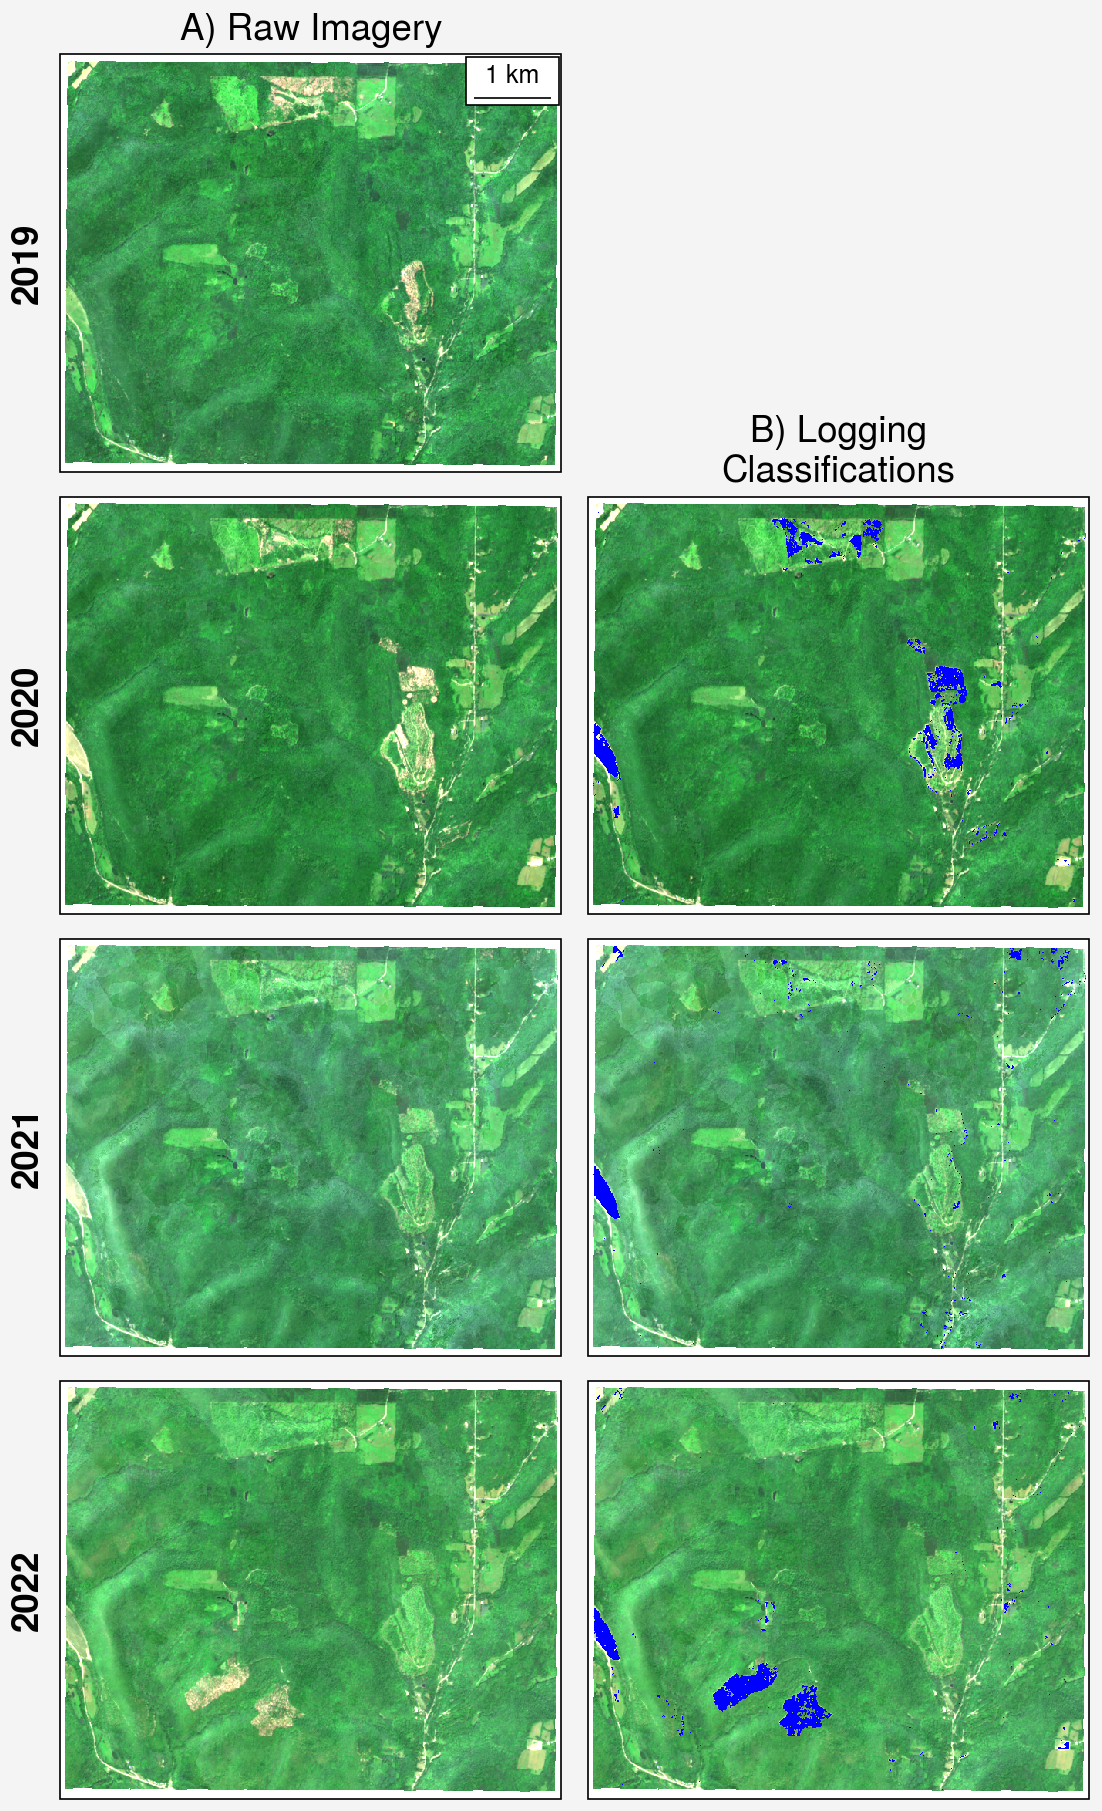

In [38]:
layout = [[1,0],
          [2, 3],
          [4, 5],
          [6, 7]]

fig, axes = uplt.subplots(layout, share=False, proj=dest_crs, fontsize=12, figsize=('140mm', '230mm'))

af_extent = [arnot_forest_1_reproj_bounds[0], arnot_forest_1_reproj_bounds[2], arnot_forest_1_reproj_bounds[1], arnot_forest_1_reproj_bounds[3]]

# Base Maps
axes[0].imshow(arnot_forest_2019, transform=dest_crs,
               extent=af_extent)
axes[0].set_extent(af_extent, crs=dest_crs)
add_scalebar(axes[0], 1000)

axes[1].imshow(arnot_forest_2020, transform=dest_crs,
               extent=af_extent)
axes[1].set_extent(af_extent, crs=dest_crs)

axes[3].imshow(arnot_forest_2021, transform=dest_crs,
               extent=af_extent)
axes[3].set_extent(af_extent, crs=dest_crs)

axes[5].imshow(arnot_forest_2022, transform=dest_crs,
               extent=af_extent)
axes[5].set_extent(af_extent, crs=dest_crs)

# Harvest Maps
axes[2].imshow(arnot_forest_2020, transform=dest_crs,
               extent=af_extent)
plot_logging(axes[2], logging_2020, dest_crs, af_extent)
axes[2].set_extent(af_extent, crs=dest_crs)

axes[4].imshow(arnot_forest_2021, transform=dest_crs,
               extent=af_extent)
plot_logging(axes[4], logging_2021, dest_crs, af_extent)
axes[4].set_extent(af_extent, crs=dest_crs)

axes[6].imshow(arnot_forest_2022, transform=dest_crs,
               extent=af_extent)
plot_logging(axes[6], logging_2022, dest_crs, af_extent)
axes[6].set_extent(af_extent, crs=dest_crs)

axes.format(
    toplabels_kw={'size':'12', 'ha':'center'},
    leftlabels=('2019', '2020', '2021', '2022'), 
    leftlabels_kw={'size':'12', 'ma':'center'})
axes[0].format(title='A) Raw Imagery', fontsize=12)
axes[2].format(title='B) Logging\nClassifications', fontsize=12)

fig.savefig('./Figures/Logging/logging_showcase.png')